In [119]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from bm3d import bm3d, BM3DProfile
import torch
import torch.nn as nn


In [120]:
def show(*imgs, titles=None, cmap="gray", figsize=(14,4)):
    plt.figure(figsize=figsize)
    if titles is None:
        titles = ["" for _ in imgs]
    for i,(im,t) in enumerate(zip(imgs, titles)):
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(im, cmap=cmap)
        plt.title(t)
        plt.axis("off")
    plt.show()


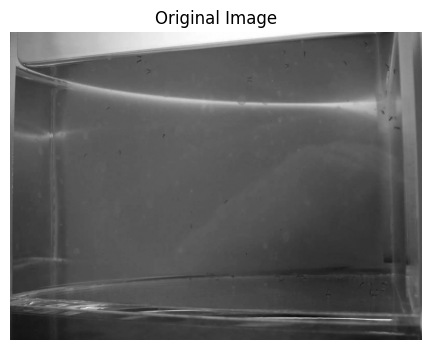

In [121]:
img = cv2.imread("input3.jpg", cv2.IMREAD_GRAYSCALE)
img = img.astype(np.float32) / 255.0
show(img, titles=["Original Image"])


In [122]:
print(img.dtype)
print(img.min(), img.max())

float32
0.3019608 1.0


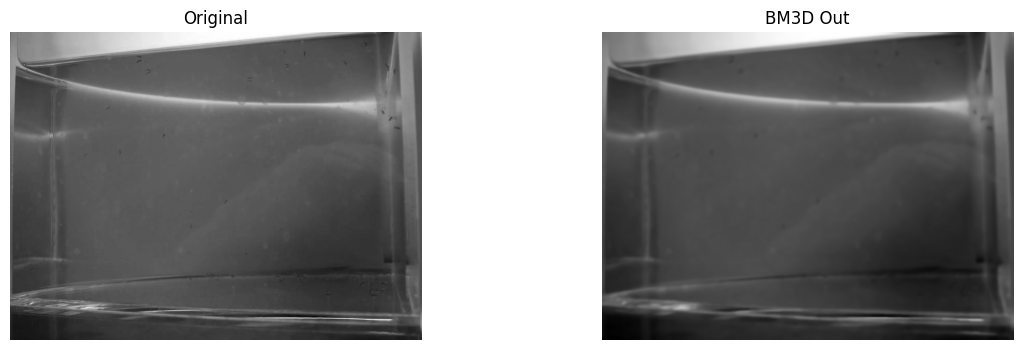

In [148]:
img_clean = img.copy()
# gray_value = (img.min() + img.max()) / 2.0
# img_clean[img <= (img.min()+0.2)] = gray_value
# img_clean[img >= (img.max()-0.1)] = gray_value
bm3d_result = bm3d(img_clean, sigma_psd=1, profile=BM3DProfile())
show(img_clean, bm3d_result, titles=["Original", "BM3D Out"])


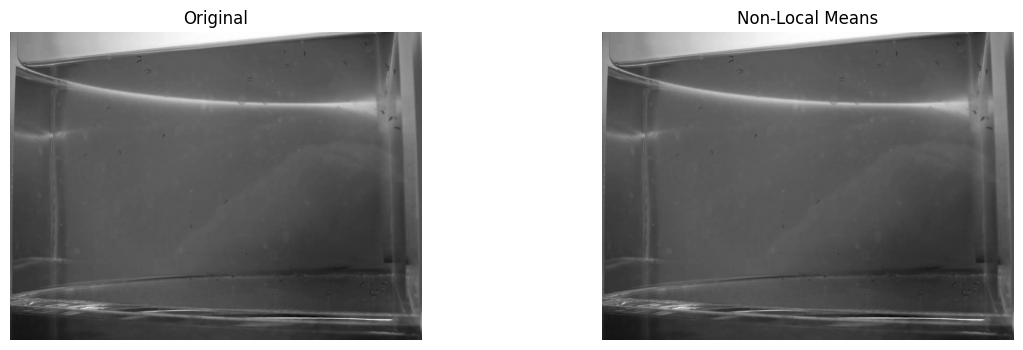

In [149]:
sigma_est = np.mean(estimate_sigma(img))
nlm = denoise_nl_means(img, h=1.15*sigma_est, fast_mode=True)
show(img, nlm, titles=["Original", "Non-Local Means"])


In [150]:
class DnCNN(nn.Module):
    def __init__(self, channels=1, depth=8, features=32):
        super().__init__()
        layers = [nn.Conv2d(channels, features, 3, padding=1), nn.ReLU(True)]
        for _ in range(depth-2):
            layers.append(nn.Conv2d(features, features, 3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.Conv2d(features, channels, 3, padding=1))
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return self.dncnn(x)

model = DnCNN(channels=2)  # 2 channels: noisy + bm3d
model.eval()


DnCNN(
  (dncnn): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(32, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

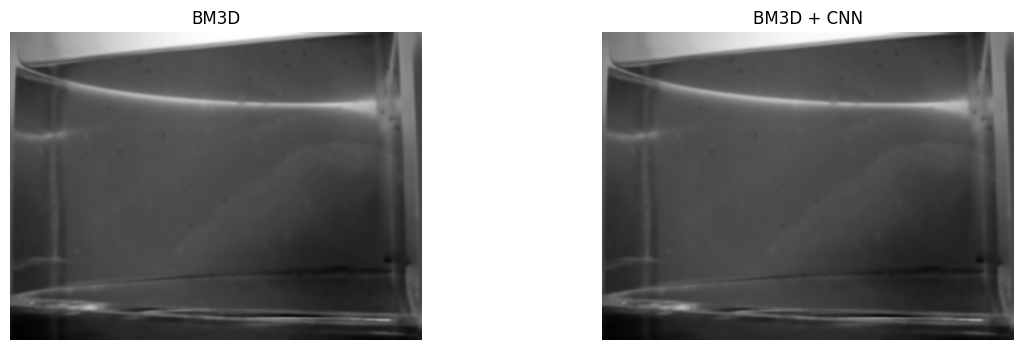

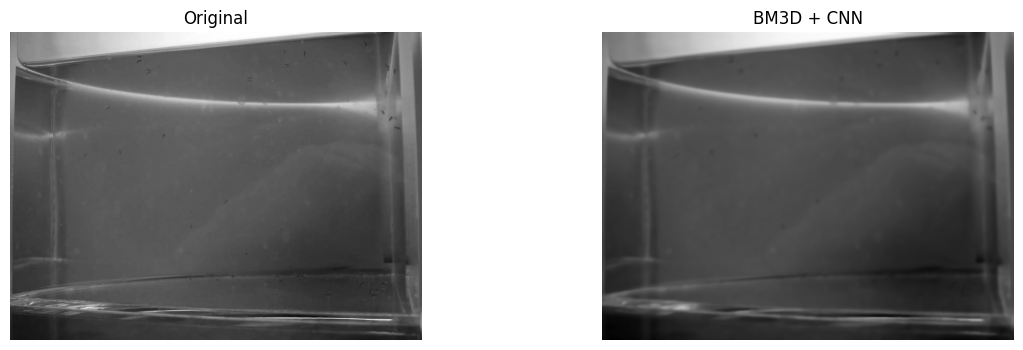

In [151]:
noisy = img
bm3d_in = bm3d_result

stack = np.stack([noisy, bm3d_in], axis=0)  # shape (2, H, W)
input_tensor = torch.from_numpy(stack).unsqueeze(0).float()  # (1, 2, H, W)

with torch.no_grad():
    residual_pred = model(input_tensor).squeeze().numpy()

hybrid_output = bm3d_in + residual_pred[0]
show(bm3d_in, hybrid_output, titles=["BM3D", "BM3D + CNN"])

show(img, hybrid_output, titles=["Original", "BM3D + CNN"])


In [152]:
from skimage.metrics import structural_similarity as ssim

orig = (noisy - noisy.min()) / (noisy.max() - noisy.min())
deno = (bm3d_result - bm3d_result.min()) / (bm3d_result.max() - bm3d_result.min())

score, ssim_map = ssim(orig, deno, data_range=1.0, full=True)

print("SSIM:", score)


SSIM: 0.9279851494458047


In [153]:
deno = (hybrid_output - hybrid_output.min()) / (hybrid_output.max() - hybrid_output.min())

score, ssim_map = ssim(orig, deno, data_range=1.0, full=True)

print("SSIM:", score)

SSIM: 0.9303529449051049


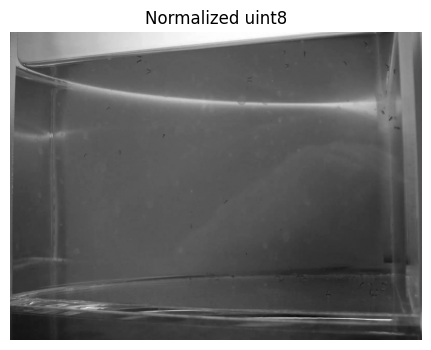

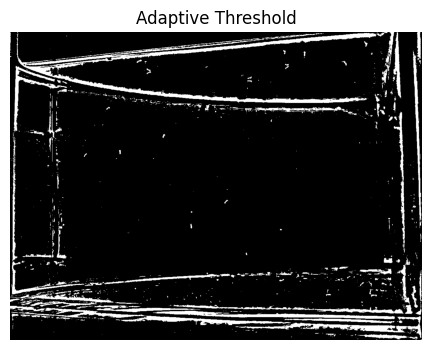

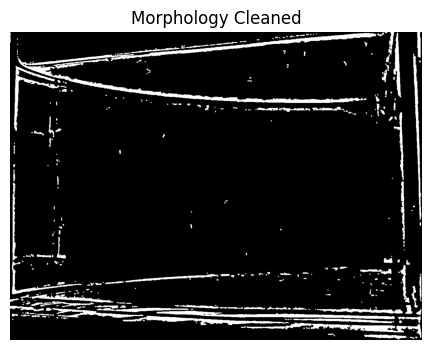

Tiny blob count: 42


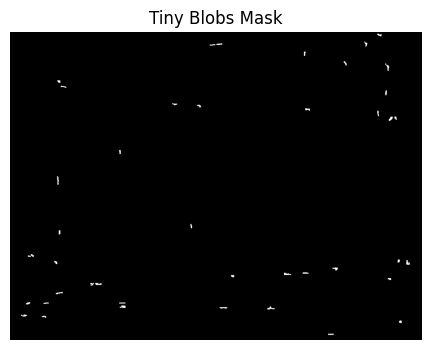

In [155]:
img_norm = (img - img.min()) / (img.max() - img.min())
img_u8 = (img_norm * 255).astype(np.uint8)
show(img_u8, titles=["Normalized uint8"])
binary = cv2.adaptiveThreshold(
    img_u8,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV,
    41,   # window size
    5     # offset
)
show(binary, titles=["Adaptive Threshold"])

kernel = np.ones((3,3), np.uint8)
clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
show(clean, titles=["Morphology Cleaned"])

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(clean)
areas = stats[1:, cv2.CC_STAT_AREA]

MIN_AREA = 50
MAX_AREA = 100

valid = (areas >= MIN_AREA) & (areas <= MAX_AREA)
valid_ids = np.where(valid)[0] + 1

print("Tiny blob count:", len(valid_ids))

filtered = np.zeros_like(clean)
for idx in valid_ids:
    filtered[labels == idx] = 255

show(filtered, titles=["Tiny Blobs Mask"])



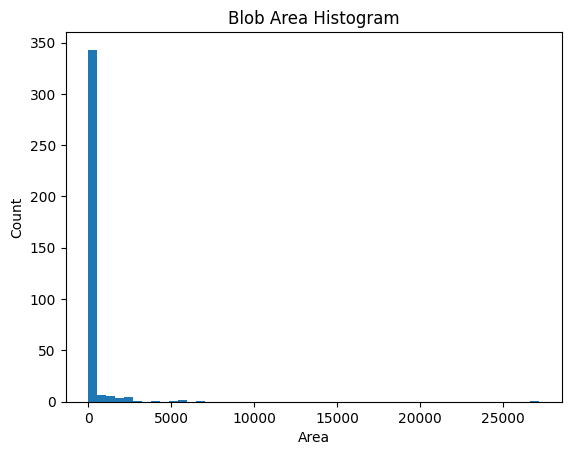

In [128]:
plt.hist(areas, bins=50)
plt.title("Blob Area Histogram")
plt.xlabel("Area")
plt.ylabel("Count")
plt.show()


Detected blobs: 10


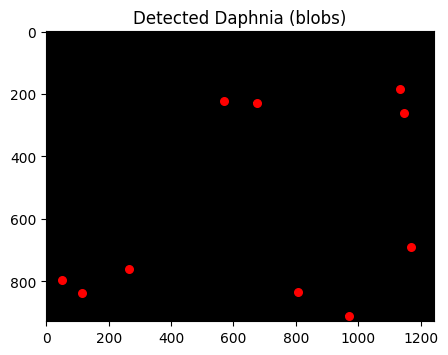

In [129]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(filtered)

areas = stats[1:, cv2.CC_STAT_AREA]
centers = centroids[1:]

print("Detected blobs:", len(areas))

plt.figure(figsize=(5,5))
plt.imshow(filtered, cmap="gray")
plt.title("Detected Daphnia (blobs)")
plt.scatter(centers[:,0], centers[:,1], s=30, c="red")
plt.show()


In [ ]:
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr

def to_float01(img):
    img = img.astype(np.float32)
    mn, mx = img.min(), img.max()
    if mx > mn:
        img = (img - mn) / (mx - mn)
    else:
        img = np.zeros_like(img, dtype=np.float32)
    return img

def laplacian_energy(img):
    img_f = to_float01(img)
    lap = cv2.Laplacian(img_f, cv2.CV_32F, ksize=3)
    return float((lap ** 2).mean())

def count_tiny_blobs(img, min_area=3, max_area=50):

    img_f = to_float01(img)
    img_u8 = (img_f * 255).astype(np.uint8)

    binary = cv2.adaptiveThreshold(
        img_u8,
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        51,
        5
    )

    kernel = np.ones((3, 3), np.uint8)
    clean = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(clean)
    areas = stats[1:, cv2.CC_STAT_AREA]

    valid = (areas >= min_area) & (areas <= max_area)
    tiny_ids = np.where(valid)[0] + 1

    return int(len(tiny_ids))

def evaluate_method(name, img_orig, img_denoised):
    assert img_orig.shape == img_denoised.shape, "Shape mismatch"


    orig_f = to_float01(img_orig)
    deno_f = to_float01(img_denoised)

    psnr_val = psnr(orig_f, deno_f, data_range=1.0)

    hf_orig = laplacian_energy(orig_f)
    hf_den  = laplacian_energy(deno_f)

    blobs_orig = count_tiny_blobs(orig_f)
    blobs_den  = count_tiny_blobs(deno_f)

    print(f"=== {name} ===")
    print(f"PSNR vs original:        {psnr_val:.4f} dB")
    print(f"Laplacian energy (orig): {hf_orig:.6f}")
    print(f"Laplacian energy (den):  {hf_den:.6f}")
    print(f"Tiny-blob count (orig):  {blobs_orig}")
    print(f"Tiny-blob count (den):   {blobs_den}")
    print()

evaluate_method("BM3D", noisy, bm3d_result)
evaluate_method("BM3D + CNN", noisy, hybrid_output)


=== BM3D ===
PSNR vs original:        25.1234 dB
Laplacian energy (orig): 0.006741
Laplacian energy (den):  0.000093
Tiny-blob count (orig):  243
Tiny-blob count (den):   40

=== BM3D + CNN ===
PSNR vs original:        25.2652 dB
Laplacian energy (orig): 0.006741
Laplacian energy (den):  0.000112
Tiny-blob count (orig):  243
Tiny-blob count (den):   38

